# Importing necessary libararies

In [100]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline

In [101]:
dir_path = os.getcwd() + '\images'
print(dir_path)

C:\Users\akash.sharma\Downloads\template\images


# Helper function for data preprocessing

In [102]:
def getLabels(filename):
    labels_dict = {}
    with open(filename, 'r') as f:
        for line in f:
            lin = line.split(',')
            l = lin[-1].strip()
            labels_dict[lin[0].strip()] = l
    return labels_dict

In [103]:
def transformData(path, label_file):
    data = []
    labels = []
    d = getLabels(label_file)
    for filename in os.listdir(path):
        if filename.endswith('.PNG'):
            image = plt.imread(path + '\\' + filename, 0)
            x = transform.resize(image, (64,64))
            data.append(x)
            labels.append(d[filename])
    return np.array(data), np.array(labels)

In [104]:
data, labels = transformData(dir_path, 'Labels.txt')

c:\users\akash.sharma\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\akash.sharma\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Samples from Dataset

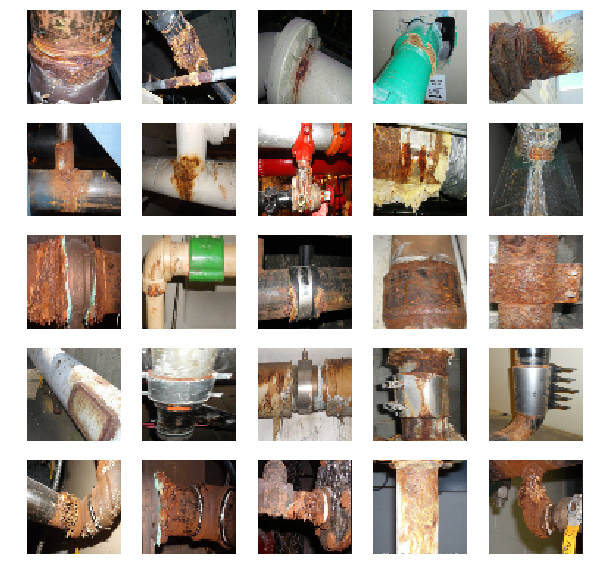

In [105]:
fig = plt.figure(figsize = (10, 10))
rows = 5
cols = 5
counter = 1
for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, counter)
        plt.axis('off')
        plt.imshow(data[counter])
        counter += 1
plt.show()

# Model Definition

In [106]:
def model(batch_image, phase):

    assert batch_image.get_shape().as_list() == [None, 64, 64,3]
    
    with tf.variable_scope('Convlayer1'):
        out1 = tf.layers.conv2d(batch_image, filters = 16,kernel_size = 3, padding ='same', name = 'Conv1')
        
        out1 = tf.nn.relu(out1, name = 'Relu1')
        outbn1 = tf.layers.batch_normalization(out1, training = phase, name = 'BatchNorm1')
        out1 = tf.layers.max_pooling2d(outbn1,pool_size = 2 , strides = 2, name = 'Maxpool1')
    with tf.variable_scope('Convlayer2'):
        out2 = tf.layers.conv2d(out1, filters = 32,kernel_size = 3, padding ='same', name = 'Conv2' )
        
        out2 = tf.nn.relu(out2, name = 'Relu2')
        outbn2 = tf.layers.batch_normalization(out2, training = phase, name = 'BatchNorm2')
        out2 = tf.layers.max_pooling2d(outbn2,pool_size = 2 , strides = 2, name = 'Maxpool2')
    with tf.variable_scope('Convlayer3'):
        out3 = tf.layers.conv2d(out2, filters = 64,kernel_size = 3, padding ='same', name = 'Conv3' )
        
        out3 = tf.nn.relu(out3, name = 'Relu3')
        outbn3 = tf.layers.batch_normalization(out3, training = phase, name = 'BatchNorm3')
        out3 = tf.layers.max_pooling2d(outbn3,pool_size = 2 , strides = 2, name = 'Maxpool3')
    with tf.variable_scope('Convlayer4'):
        out4 = tf.layers.conv2d(out3, filters = 128,kernel_size = 3, padding ='same', name = 'Conv4' )
        
        out4 = tf.nn.relu(out4, name = 'Relu4')
        outbn4 = tf.layers.batch_normalization(out4, training = phase, name = 'BatchNorm4')
        out4 = tf.layers.max_pooling2d(outbn4,pool_size = 2 , strides = 2, name = 'Maxpool4')
    
    assert out4.get_shape().as_list() == [None, 4, 4, 128]
    
    out4 = tf.reshape(out4, shape =[-1, 4*4*128 ])
    
    with tf.variable_scope('FClayerl'):
        out5 = tf.layers.dense(out4, units = 128, name = 'fc1')
        
        out5 = tf.nn.relu(out5)
        outbn5 = tf.layers.batch_normalization(out5, training = phase, name = 'BatchNorm4')
    with tf.variable_scope('FClayer2'):
        out6 = tf.layers.dense(outbn5, units = 3, name = 'fc2')

    return out6

In [107]:
def train(batch_image, labels, phase):

    logit= model(batch_image, phase)
    true_labels = labels
    true_labels= tf.cast(true_labels, dtype = tf.int64)
    with tf.variable_scope('Loss'):
        loss = tf.losses.sparse_softmax_cross_entropy(labels = true_labels, logits = logit)
    optimizer = tf.train.AdamOptimizer()
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_op = optimizer.minimize(loss)
    predictions = tf.argmax(logit, 1)
    with tf.variable_scope('Accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels, predictions), tf.float32))



    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.image('train_image', batch_image)
    model_spec = {}
    model_spec['loss']  = loss
    model_spec['train_op'] = train_op
    model_spec['accuracy'] = accuracy
    model_spec['summary_op'] = tf.summary.merge_all()

    return model_spec

# Training

In [108]:
if __name__ == '__main__':
    tf.reset_default_graph()
    data, labels = transformData(dir_path, 'Labels.txt')
    np.random.seed(seed = 2018)
    index = np.random.permutation(len(data))
    data = data[index]
    labels = labels[index]
    with tf.variable_scope('Placeholders'):
        X = tf.placeholder('float',shape=[None,64,64,3],name='image')
        Y = tf.placeholder('int32', shape=[None], name='labels')
        batch_size = tf.placeholder(dtype = tf.int64)
        phase = tf.placeholder(dtype = tf.bool, name='is_training') 



    model_spec = train(X , Y, phase)

    loss = model_spec['loss']
    train_op = model_spec['train_op']
    accuracy = model_spec['accuracy']
    summary = model_spec['summary_op']
    BATCH_SIZE = 4
    EPOCHS = 30
    
    n_batches = (len(data) + BATCH_SIZE - 1)// BATCH_SIZE
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    increment_global_step_op = tf.assign(global_step, global_step+1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #summary_writer = tf.summary.FileWriter('sign_classifier/tensorboardlogs/run10_placeholder/', sess.graph)
        saver = tf.train.Saver()
        print('Training...')
        for i in range(EPOCHS):
            # initialise iterator with train data
            tot_loss = 0
            end = 0    
            for n in range(n_batches):
                start = end
                if (end+ BATCH_SIZE < len(data)):    
                    end = end + BATCH_SIZE
                else:
                    end = len(data)
                image_batch = data[start:end ]
                label_batch = labels[start:end]
                
                _, loss_value ,step= sess.run([train_op, loss, increment_global_step_op], feed_dict = {X: image_batch, Y: label_batch, batch_size: BATCH_SIZE, phase: True})
                tot_loss += loss_value
                print('Epoch: {}, Step: {} completed'.format(i, step))
                
                if step % 100 == 0:
                    saver.save(sess, 'RustNet/checkpoints', global_step = step)

            print("Iter: {}, Loss: {:.4f}".format(i, tot_loss))
        train_accuracy = sess.run(accuracy, feed_dict = {X: data, Y: labels, batch_size: len(data), phase: False})
        print('Train Accuracy: {}'.format(train_accuracy))


c:\users\akash.sharma\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\akash.sharma\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Training...
Epoch: 0, Step: 1 completed
Epoch: 0, Step: 2 completed
Epoch: 0, Step: 3 completed
Epoch: 0, Step: 4 completed
Epoch: 0, Step: 5 completed
Epoch: 0, Step: 6 completed
Epoch: 0, Step: 7 completed
Epoch: 0, Step: 8 completed
Epoch: 0, Step: 9 completed
Epoch: 0, Step: 10 completed
Epoch: 0, Step: 11 completed
Epoch: 0, Step: 12 completed
Epoch: 0, Step: 13 completed
Epoch: 0, Step: 14 completed
Epoch: 0, Step: 15 completed
Epoch: 0, Step: 16 completed
Epoch: 0, Step: 17 completed
Epoch: 0, Step: 18 completed
Iter: 0, Loss: 25.4021
Epoch: 1, Step: 19 completed
Epoch: 1, Step: 20 completed
Epoch: 1, Step: 21 completed
Epoch: 1, Step: 22 completed
Epoch: 1, Step: 23 completed
Epoch: 1, Step: 24 completed
Epoch: 1, Step: 25 completed
Epoch: 1, Step: 26 completed
Epoch: 1, Step: 27 completed
Epoch: 1, Step: 28 completed
Epoch: 1, Step: 29 completed
Epoch: 1, Step: 30 completed
Epoch: 1, Step: 31 completed
Epoch: 1, Step: 32 completed
Epoch: 1, Step: 33 completed
Epoch: 1, Step: 3

Epoch: 14, Step: 265 completed
Epoch: 14, Step: 266 completed
Epoch: 14, Step: 267 completed
Epoch: 14, Step: 268 completed
Epoch: 14, Step: 269 completed
Epoch: 14, Step: 270 completed
Iter: 14, Loss: 0.8206
Epoch: 15, Step: 271 completed
Epoch: 15, Step: 272 completed
Epoch: 15, Step: 273 completed
Epoch: 15, Step: 274 completed
Epoch: 15, Step: 275 completed
Epoch: 15, Step: 276 completed
Epoch: 15, Step: 277 completed
Epoch: 15, Step: 278 completed
Epoch: 15, Step: 279 completed
Epoch: 15, Step: 280 completed
Epoch: 15, Step: 281 completed
Epoch: 15, Step: 282 completed
Epoch: 15, Step: 283 completed
Epoch: 15, Step: 284 completed
Epoch: 15, Step: 285 completed
Epoch: 15, Step: 286 completed
Epoch: 15, Step: 287 completed
Epoch: 15, Step: 288 completed
Iter: 15, Loss: 0.7115
Epoch: 16, Step: 289 completed
Epoch: 16, Step: 290 completed
Epoch: 16, Step: 291 completed
Epoch: 16, Step: 292 completed
Epoch: 16, Step: 293 completed
Epoch: 16, Step: 294 completed
Epoch: 16, Step: 295 com

Epoch: 28, Step: 519 completed
Epoch: 28, Step: 520 completed
Epoch: 28, Step: 521 completed
Epoch: 28, Step: 522 completed
Iter: 28, Loss: 0.1963
Epoch: 29, Step: 523 completed
Epoch: 29, Step: 524 completed
Epoch: 29, Step: 525 completed
Epoch: 29, Step: 526 completed
Epoch: 29, Step: 527 completed
Epoch: 29, Step: 528 completed
Epoch: 29, Step: 529 completed
Epoch: 29, Step: 530 completed
Epoch: 29, Step: 531 completed
Epoch: 29, Step: 532 completed
Epoch: 29, Step: 533 completed
Epoch: 29, Step: 534 completed
Epoch: 29, Step: 535 completed
Epoch: 29, Step: 536 completed
Epoch: 29, Step: 537 completed
Epoch: 29, Step: 538 completed
Epoch: 29, Step: 539 completed
Epoch: 29, Step: 540 completed
Iter: 29, Loss: 0.1827
Train Accuracy: 0.9154929518699646


# Restoring Tensorflow graph from latest checkpoint

In [109]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph('RustNet\\checkpoints-500.meta')
g = tf.get_default_graph()
X = g.get_operation_by_name('Placeholders/image').outputs[0]
Y = g.get_operation_by_name('Placeholders/labels').outputs[0]
batch_size = g.get_operation_by_name('Placeholders/Placeholder').outputs[0]
phase = g.get_operation_by_name('Placeholders/is_training').outputs[0]
output = g.get_operation_by_name('FClayer2/fc2/BiasAdd').outputs[0]
inputs = g.get_operation_by_name('Convlayer1/Conv1/Conv2D').inputs[0]

# Prediction using saved model

In [110]:
#prediction on nine random images from datset
_data = data[:9]
_labels = labels[:9]
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('RustNet\\'))
    logit, _image = sess.run([output, inputs], feed_dict = {X: _data, Y: _labels, batch_size: len(_data), phase: False})
    print('Predicted Label: {}'.format(np.argmax(logit, axis = 1)))

INFO:tensorflow:Restoring parameters from RustNet\checkpoints-500
Predicted Label: [2 1 2 1 1 1 1 1 1]


# Groundtruth

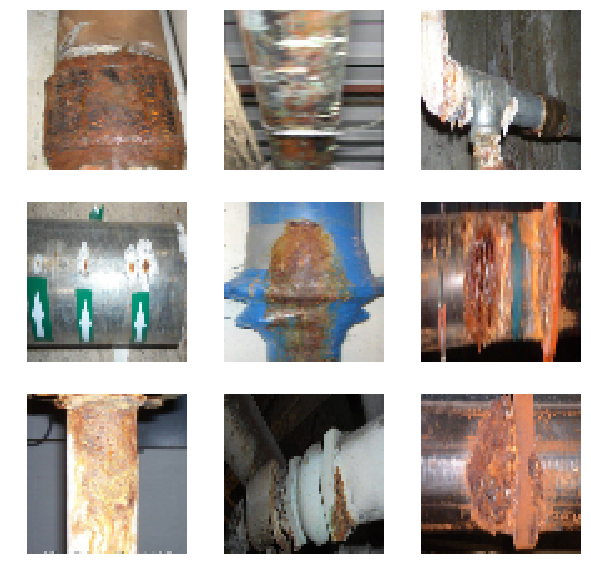

In [111]:
fig = plt.figure(figsize = (10, 10))
rows = 3
cols = 3
counter = 1
for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, counter)
        plt.axis('off')
        plt.imshow(_image[counter-1])
        counter += 1
plt.show()